In [1]:
import yfinance as yf 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import warnings
warnings.filterwarnings('ignore')

end_date = datetime.datetime.now()

# Get Data

In [2]:
start_date = '2016-01-01'
ticker_list = ['AAPL', 'AMZN','PEP', 'SNE']
all_data = yf.download(ticker_list, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


## Alter data to use, and split data for portfolio creation and forward testing

In [3]:
all_prices = all_data['Adj Close']
all_prices = all_prices.reset_index(inplace=False)
all_prices = all_prices.set_index('Date')
halfway = int(len(all_prices.index)/2)
# Split prices into front prices for portfolio
# and back prices for future testing
front_prices = all_prices.iloc[:halfway,:]
back_prices = all_prices.iloc[halfway:,:]

## Calculate returns and stock cov/cor matrices

In [4]:
returns = front_prices.pct_change()
returns.columns
cov_matrix = returns.apply(lambda x: np.log(1+x)).cov()
print(cov_matrix)
corr_matrix = returns.apply(lambda x: np.log(1+x)).corr()
print(corr_matrix)

          AAPL      AMZN       PEP       SNE
AAPL  0.000171  0.000081  0.000025  0.000079
AMZN  0.000081  0.000253  0.000027  0.000042
PEP   0.000025  0.000027  0.000057  0.000035
SNE   0.000079  0.000042  0.000035  0.000363
          AAPL      AMZN       PEP       SNE
AAPL  1.000000  0.388842  0.249736  0.316377
AMZN  0.388842  1.000000  0.220511  0.139714
PEP   0.249736  0.220511  1.000000  0.240441
SNE   0.316377  0.139714  0.240441  1.000000


## Expected Return

In [5]:
er = (returns.mean())
# Annualizing average daily returns
for x in range(0,4):
    er[x]=((er[x]+1)**250)-1
print(er)

AAPL    0.255406
AMZN    0.495694
PEP     0.109729
SNE     0.457151
dtype: float64


# Create portfolios to find EF

In [6]:
p_ret=[]
p_vol=[]
p_weights = []

num_assets = len(returns.columns)
num_portfolios = int(1000*1.5**(num_assets))

In [7]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    rets = np.dot(weights, er)
    p_ret.append(rets)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(len(returns.index))
    p_vol.append(ann_sd)

## Compile portfolios into dataframe

In [8]:
data1 = {'Returns': p_ret, 'Volatility': p_vol}
for counter, symbol in enumerate(returns.columns.tolist()):
    data1[symbol+ ' Weight'] = [w[counter] for w in p_weights]
portfolios = pd.DataFrame(data1)

### Find risk free rate for sharpe ratio

In [9]:
rf_data = yf.download('^TNX', start_date, end_date)
#print(rf_data)
rf_returns = rf_data['Adj Close']
rfr = (rf_returns.mean())/100 # divide by 100 to convert to x percent
portfolios['Sharpe']=(portfolios['Returns']-rfr)/portfolios['Volatility']
portfolios.head(3)

[*********************100%***********************]  1 of 1 completed


,Returns,Volatility,AAPL Weight,AMZN Weight,PEP Weight,SNE Weight,Sharpe
0,0.309449,0.256207,0.458758,0.005718,0.159374,0.376151,1.119380
1,0.371480,0.234133,0.055005,0.362719,0.254889,0.327386,1.489850
2,0.363815,0.281042,0.017063,0.136245,0.273860,0.572832,1.213905


### Weighting with best Sharpe Ratio

In [19]:
sharpe = (portfolios[portfolios['Sharpe']==portfolios['Sharpe'].max()])
type(sharpe)

pandas.core.frame.DataFrame

## Plot Efficient Frontier

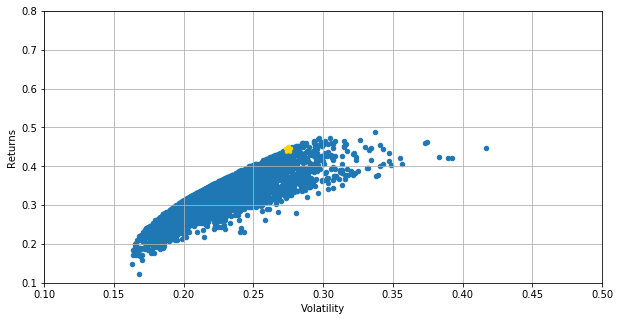

In [11]:
portfolios.plot.scatter(figsize=(10,5), x='Volatility', y='Returns', grid=True)
plt.scatter(x=sharpe['Volatility'], y=sharpe['Returns'], color= 'gold', marker='*', lw=4.)
plt.xlim(.1, .5)
plt.ylim(.1, .8)
plt.show()

# Test performance in future

In [20]:
backtest_data = back_prices.copy()
initial_capital = 100000.0
print(backtest_data)

                  AAPL         AMZN         PEP        SNE
Date                                                      
2018-02-06  157.866333  1442.839966  106.027573  50.140518
2018-02-07  154.486877  1416.780029  105.971550  49.498569
2018-02-08  150.235947  1350.500000  102.843742  46.377754
2018-02-09  152.073547  1339.599976  103.805443  46.466640
2018-02-12  158.198883  1386.229980  104.505692  47.671516
...                ...          ...         ...        ...
2020-03-05  292.920013  1924.030029  138.100006  63.439999
2020-03-06  289.029999  1901.089966  137.259995  63.119999
2020-03-09  266.170013  1800.609985  130.160004  58.529999
2020-03-10  285.339996  1891.819946  134.139999  60.330002
2020-03-11  275.429993  1820.859985  129.750000  57.790001

[527 rows x 4 columns]


### Pull weights from optimal sharpe value portfolio

In [13]:
opt_weights = (sharpe.iloc[0:1,2:-1])
opt_weights = opt_weights.values
opt_weights = (opt_weights[0])

### Create df of positions for amt of shares per stock based upon portfolio weights

In [14]:
positions = pd.DataFrame(index=backtest_data.index).fillna(0.0)
for counter, symbol in enumerate(all_prices.columns.tolist()):
    positions[symbol+ ' Shares'] = (opt_weights[counter]*initial_capital)/back_prices.iloc[0,counter]

### Create list of column names for Portfolio df, fill in df values by multiplying stock value by stock position

In [15]:
# Create list of columns for portfolio
col_list= []
for counter, symbol in enumerate(all_prices.columns.tolist()):
    col_list.append(symbol+ ' Value')
# Initialize portfolio
portfolio = pd.DataFrame(backtest_data.values*positions.values, columns=col_list, index=backtest_data.index)
portfolio['total'] = portfolio.sum(axis=1)
portfolio['returns'] = portfolio['total'].pct_change()

# Show Portfolio performance 

### Get index returns and standardize prices

In [16]:
index_all_data = yf.download('^GSPC', start_date, end_date)
index_all_data['returns'] = index_all_data['Adj Close'].pct_change()

halfway = int(len(index_all_data.index)/2)
# Split prices into front prices for portfolio
# and back prices for future testing
index_front_data = index_all_data.iloc[:halfway,:]
index_back_data = index_all_data.iloc[halfway:,:]

[*********************100%***********************]  1 of 1 completed


In [17]:
portfolio['Std Value'] = portfolio['total'] / portfolio['total'].iloc[0] * 100
index_back_data['Std Value'] = index_back_data['Adj Close'] / index_back_data['Adj Close'].iloc[0] * 100
#print(portfolio.tail(5))
#print(index_back_data.tail(5))

### Plot portfolio value against index (standardized)


Current portfolio value is: $124,520.73
Portfolio annualized return is: 10.96%
Index annualized return is: 1.64%


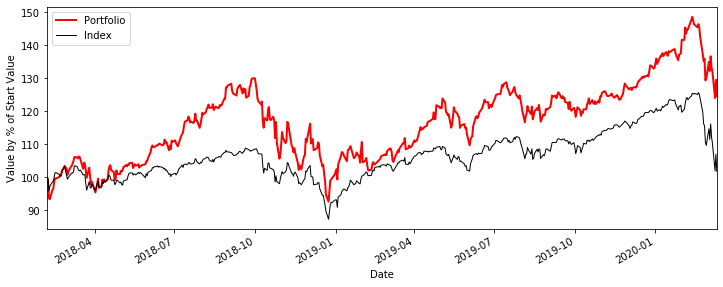

In [18]:
fig = plt.figure(figsize=(12,10))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(211, ylabel='Value by % of Start Value')
portfolio['Std Value'].plot(ax=ax1, color='red', lw=2.)
index_back_data['Std Value'].plot(ax=ax1, color='black', lw=1.)
plt.legend(labels=['Portfolio', 'Index'])

# Get final value of portfolio
portfolio_value = (portfolio.iloc[-1,-3])
# Calc cumulative returns of port and index
cum_port_change = (1+portfolio['returns']).cumprod()
cum_index_change = (1+index_back_data['returns']).cumprod()
# Annualize
portfolio_cum_ret = (cum_port_change**(250/len(portfolio.index)))-1
index_cum_ret = (cum_index_change**(250/len(index_back_data.index)))-1
#print(portfolio_cum_ret)
# Slice most recent date
portfolio_ret= portfolio_cum_ret[-1]
index_ret = index_cum_ret[-1]

print('\nCurrent portfolio value is: $'+ str('{:,.2f}'.format(portfolio_value)))
print('Portfolio annualized return is: '+ str("{:.2%}".format(portfolio_ret)))
print('Index annualized return is: '+ str("{:.2%}".format(index_ret)))
plt.show()